In [59]:
from pyspark.sql import SparkSession
import math
from pyspark.sql.functions import stddev
from pyspark.sql.functions import col
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np 
spark = SparkSession.builder.master('local').getOrCreate()

In [60]:
import os

df = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/EQWorks-Tony-Interview/data/DataSample.csv'))
df.printSchema()

# I noticed that column " TimeSt" had a whitespace character so I adjusted it.
df = df.withColumnRenamed(" TimeSt","TimeSt")
df.printSchema()
df.show()

dfPOI = spark.read.options(
    header='True',
    inferSchema='True',
    delimiter=',',
).csv(os.path.expanduser('~/EQWorks-Tony-Interview/data/POIList.csv'))

# I noticed that column " Latitude" had a whitespace character so I adjusted it.
dfPOI = dfPOI.withColumnRenamed(" Latitude","Latitude")
dfPOI.printSchema()


root
 |-- _ID: integer (nullable = true)
 |--  TimeSt: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)

root
 |-- _ID: integer (nullable = true)
 |-- TimeSt: timestamp (nullable = true)
 |-- Country: string (nullable = true)
 |-- Province: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)

+-------+--------------------+-------+--------+------------+--------+---------+
|    _ID|              TimeSt|Country|Province|        City|Latitude|Longitude|
+-------+--------------------+-------+--------+------------+--------+---------+
|4516516|2017-06-21 00:00:...|     CA|      ON|    Waterloo|43.49347|-80.49123|
|4516547|2017-06-21 18:00:...|     CA|      ON|      London| 42.9399| -81.2709|
|4516550|2017-06-21 15:00:...|     CA|   

In [61]:
# We can see that there are 22025 requests.
print((df.count(), len(df.columns)))

(22025, 7)


In [62]:
'''
1. Cleanup

Might not be the most efficient way to clean the data but I grouped by TimeSt, Latitude, Longitude and got the count
of each group. If the group count was not 1, it can be considered a "suspicious request" since it has the same 
geoinfo + timestamp. We remove those requests which are not unique.

I didn't use dropDuplicate() because it keeps the first request. I'm assuming that we are removing ALL sus requests.

However, this method removes the other columns so we need to join with the original dataframe to get the other colunms
back. Rename the columns in dataframe2 so they don't match the column names in dataframe1. This is necessary to select
and keep the columns in dataframe1 later on.
'''

df2 = df.groupby(['TimeSt','Latitude','Longitude']).count().where('count = 1')
df2 = df2.drop('count')
df2 = df2.withColumnRenamed("TimeSt", "TimeSt2")
df2 = df2.withColumnRenamed("Latitude", "Latitude2")
df2 = df2.withColumnRenamed("Longitude", "Longitude2") 
df2.show()
df2.count()

+--------------------+---------+----------+
|             TimeSt2|Latitude2|Longitude2|
+--------------------+---------+----------+
|2017-06-21 08:00:...|  42.9399|  -81.2709|
|2017-06-21 03:00:...|  45.5047|  -73.5558|
|2017-06-21 07:01:...|  43.5776|  -80.2201|
|2017-06-21 10:01:...|  48.3738|  -89.2779|
|2017-06-21 20:02:...|  42.2825|  -83.0372|
|2017-06-21 07:02:...|  53.4044| -113.5237|
|2017-06-21 22:05:...|  45.5771|  -73.6873|
|2017-06-21 15:05:...|    53.55| -113.1333|
|2017-06-21 19:06:...| 51.04938|-113.94482|
|2017-06-21 10:06:...|  43.6414|  -79.4151|
|2017-06-21 15:07:...| 51.04176|-113.99981|
|2017-06-21 00:09:...|  43.6618|  -79.7034|
|2017-06-21 03:10:...|  51.1264| -114.1419|
|2017-06-21 02:10:...|  43.4381|  -80.5099|
|2017-06-21 08:11:...|  45.3804|  -75.7468|
|2017-06-21 11:12:...|  53.4154| -113.4178|
|2017-06-21 08:12:...|  43.7479|   -81.702|
|2017-06-21 19:13:...|  51.0081|  -114.073|
|2017-06-21 10:13:...|  43.1941|  -79.2525|
|2017-06-21 04:13:...|  43.4397|

17973

In [63]:
# Join df2 and df, select all the columns from df, and set as df3. 
# We now have a new dataframe with the original schema and all the sus requests removed.
df3 = df.join(df2, (df.TimeSt == df2.TimeSt2) & (df.Latitude == df2.Latitude2) & (df.Longitude == df2.Longitude2)).select(df["*"])
df3.show()

# Same count as df2.
df3.count()

+-------+--------------------+-------+--------+------------+--------+---------+
|    _ID|              TimeSt|Country|Province|        City|Latitude|Longitude|
+-------+--------------------+-------+--------+------------+--------+---------+
|4516516|2017-06-21 00:00:...|     CA|      ON|    Waterloo|43.49347|-80.49123|
|4516547|2017-06-21 18:00:...|     CA|      ON|      London| 42.9399| -81.2709|
|4516550|2017-06-21 15:00:...|     CA|      ON|      Guelph| 43.5776| -80.2201|
|4516600|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773|
|4516613|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773|
|4516693|2017-06-21 14:00:...|     CA|      ON|   Kitchener| 43.4381| -80.5099|
|4516771|2017-06-21 10:00:...|     CA|      ON|      Sarnia|  42.961|  -82.373|
|4516915|2017-06-21 15:00:...|     CA|      ON|      London| 43.0091| -81.1765|
|4516953|2017-06-21 16:00:...|     CA|      ON|   Kitchener| 43.4278| -80.5135|
|4516966|2017-06-21 01:00:...|     CA|  

17973

In [64]:
'''
2. Label
'''

# Use collect() to create two lists with all the request ID and geoinfo, and all the POI geoinfo.
dataReq = df3.select(col("_ID"), col("Latitude"),col("Longitude")).collect()
dataPOI = dfPOI.collect()

# Initialize closestPOI dictionary for future pairing key:value ("POI":distance). Initialize closestArray array to later
# hold all minimum distances.
closestPOI = {}
closestArray = []

# Nested for loop to calcuate distance between each request and POI.
for i in range(len(dataReq)):
    for j in range(len(dataPOI)):
        cPOI_dist = sqrt((dataReq[i][1]-dataPOI[j][1])**2 + (dataReq[i][2]-dataPOI[j][2])**2)
        cPOI = dataPOI[j][0]
        # Create key:value pair and append in dictionary
        closestPOI[cPOI]= cPOI_dist
        
    # Use min() method to find minimum key:value pair.
    closest = min(closestPOI, key=closestPOI.get)
    
    # Append minimum to array
    closestArray.append((dataReq[i][0],closest, closestPOI[closest]))
    closestPOI.clear()

# Declare columns for new Closest POI dataframe.
poiColumns = ["_ID","ClosestPOI","MinDistance"]

# Use previously declared columns and closestArray to make new dataframe.
dfClosestPOI = spark.createDataFrame(data=closestArray, schema = poiColumns)
dfClosestPOI.show()
print(dfClosestPOI.count())

+-------+----------+--------------------+
|    _ID|ClosestPOI|         MinDistance|
+-------+----------+--------------------+
|4518918|      POI3|   8.125911567622241|
|4535779|      POI3|0.019776784799349703|
|4547425|      POI3|   6.932241785066144|
|4561012|      POI3|   15.96865450977687|
|4576329|      POI3|  10.009751820181007|
|4578136|      POI1| 0.14676273179863916|
|4617922|      POI3| 0.13336003905592997|
|4618117|      POI1|   0.352454842845139|
|4630340|      POI1|  2.5386424086044492|
|4638863|      POI3|   6.143854746510285|
|4655334|      POI1|  2.5566244455189358|
|4673153|      POI3|   6.412982775169214|
|4685459|      POI1|   2.507154991986937|
|4688073|      POI3|   7.249724615267606|
|4695029|      POI3|  2.1853442732478046|
|4706435|      POI1|  0.1473602274869269|
|4708487|      POI3|   8.327077520836285|
|4720047|      POI1|   2.605122924402031|
|4720600|      POI3|   6.144379589870484|
|4721236|      POI3|    7.17659548097961|
+-------+----------+--------------

In [65]:
# Join new dataframe with df3 based on column "_ID" to get full request data
dfClean = df3.join(dfClosestPOI, ['_ID'])
dfClean.show()
dfClean.count()

+-------+--------------------+-------+--------+------------+--------+---------+----------+------------------+
|    _ID|              TimeSt|Country|Province|        City|Latitude|Longitude|ClosestPOI|       MinDistance|
+-------+--------------------+-------+--------+------------+--------+---------+----------+------------------+
|4516516|2017-06-21 00:00:...|     CA|      ON|    Waterloo|43.49347|-80.49123|      POI3| 7.216086686821121|
|4516547|2017-06-21 18:00:...|     CA|      ON|      London| 42.9399| -81.2709|      POI3| 8.125911567622241|
|4516550|2017-06-21 15:00:...|     CA|      ON|      Guelph| 43.5776| -80.2201|      POI3| 6.932241785066144|
|4516600|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773|      POI3| 7.716841105596059|
|4516613|2017-06-21 15:00:...|     CA|      ON|   Stratford| 43.3716| -80.9773|      POI3| 7.716841105596059|
|4516693|2017-06-21 14:00:...|     CA|      ON|   Kitchener| 43.4381| -80.5099|      POI3| 7.249724615267606|
|4516771|2

17973

In [66]:
'''
3. Analysis
'''

# Create new dataframe for averages by grouping by ClosestPOI and calculating average of each group.
dfAvg = dfClean.groupBy("ClosestPOI").avg("MinDistance")

# Create new dataframe for standard deviation by grouping by ClosestPOI and calculating stddev of each group.
dfStddev = dfClean.groupBy("ClosestPOI").agg(stddev("MinDistance"))

# Join both dataframes
df5 = dfAvg.join(dfStddev, ['ClosestPOI'])
df5.show()

+----------+-----------------+------------------------+
|ClosestPOI| avg(MinDistance)|stddev_samp(MinDistance)|
+----------+-----------------+------------------------+
|      POI4|8.522389808711136|      27.334583163851153|
|      POI1| 3.35311176894019|       3.849640081597118|
|      POI3|5.537919139655487|      2.8587108750939803|
+----------+-----------------+------------------------+



In [67]:
# Group dfClean by ClosestPOI and collect their latitude and longitude in lists
# These lists will be considered as respective x and y value lists for plotting later on.
df5 = dfClean.groupby("ClosestPOI").agg(F.collect_list("Latitude"),F.collect_list("Longitude"))
df5.show()

+----------+----------------------+-----------------------+
|ClosestPOI|collect_list(Latitude)|collect_list(Longitude)|
+----------+----------------------+-----------------------+
|      POI4|  [46.1149, 46.1183...|   [-60.20269, -64.7...|
|      POI1|  [53.4044, 53.55, ...|   [-113.5237, -113....|
|      POI3|  [42.9399, 45.5047...|   [-81.2709, -73.55...|
+----------+----------------------+-----------------------+



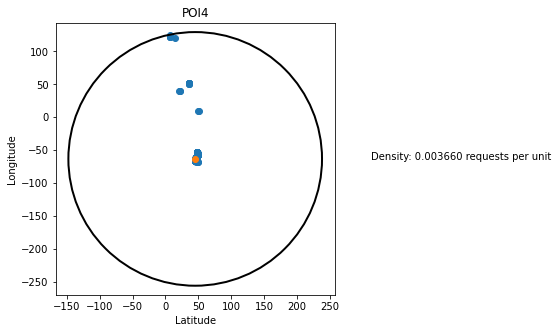

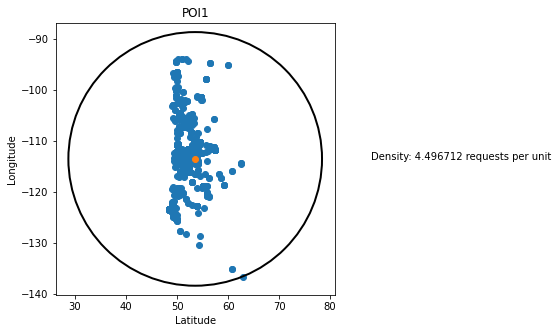

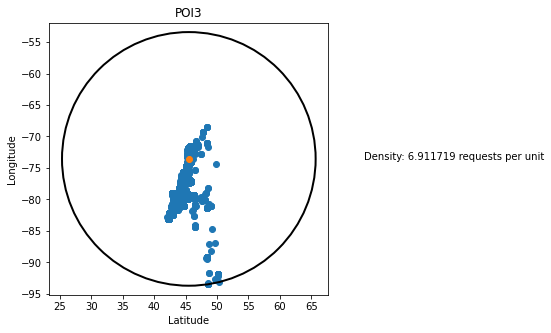

In [68]:
# Convert dataframe of latitude and longitude lists to array
reqArray = df5.collect()

# Group dfClean by ClosestPOI and calculate max value. Convert group to array.
# The circle radius will be the max distance to ensure that all other points are within the circle.
maxArray = dfClean.groupBy("ClosestPOI").max("MinDistance").collect()

plt.rcParams["figure.figsize"] = (5,5)

for i in range(len(reqArray)):
    
    # Use where() condition to find corresponding POI row entry in the POI dataframe.
    poiSearch = dfPOI.where(dfPOI.POIID==reqArray[i][0]).collect()
    
    # Use first and second index to set latitude and longitude as the center point for circle
    center = (poiSearch[0][1], poiSearch[0][2])
    
    # Set x as the list of latitude values
    x = reqArray[i][1]
    
    # Set y as the list of longitude values
    y = reqArray[i][2]
    
    # Declare radius
    radius = maxArray[i][1]
    
    # Calculate density
    density = len(x)/(math.pi * radius * radius)
    
    # Plot circle and points of each POI, with the center of the circle being the POI
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.scatter(poiSearch[0][1], poiSearch[0][2])
    circle1 = plt.Circle( center, radius, fill = False, linewidth = 2 )
    ax.set_aspect('equal', adjustable='datalim')
    ax.add_patch(circle1)
    plt.text(1, 0.5, 'Density: {:.6f} requests per unit'.format(density), fontsize=10, transform=plt.gcf().transFigure)
    plt.title(reqArray[i][0])
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.show()

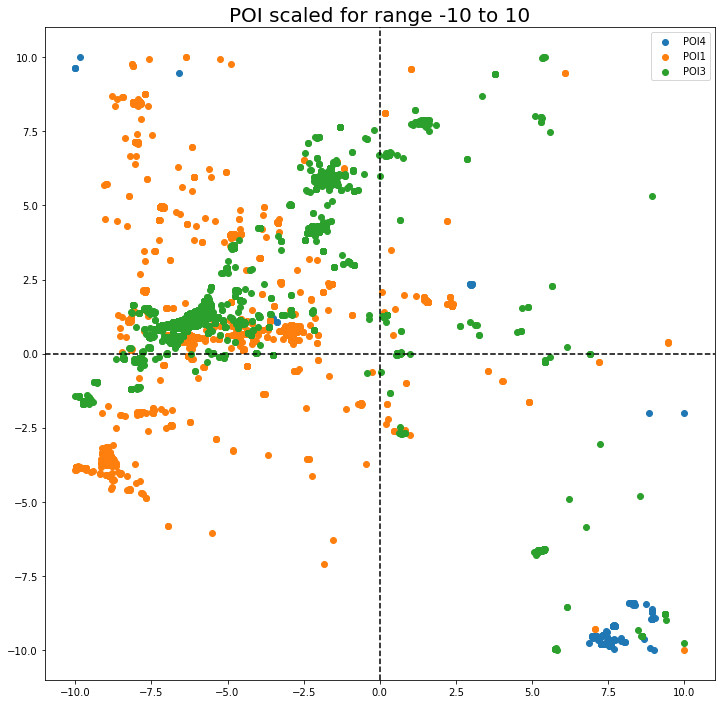

In [70]:
'''
4. Modelling
'''

# Loop through reqArray and normalize each value of latitude and longitude to fit a scale of -10 to 10
# Plot all 3 rows on the same plot (different colors) to visualize everything
plt.rcParams["figure.figsize"] = (12,12)
def normalize(valueArray, rangeMax, rangeMin):
    normArray = []
    maxVal = max(valueArray)
    minVal = min(valueArray)
    for value in valueArray:
        normVal = ((value-minVal)/(maxVal-minVal))*(rangeMax-rangeMin)+rangeMin
        normArray.append(normVal)
    return normArray

for i in range(len(reqArray)):
    x = normalize(reqArray[i][1], 10, -10)
    y = normalize(reqArray[i][2], 10, -10)
    plt.scatter(x,y, label = reqArray[i][0])

plt.legend()

# adding vertical line in data co-ordinates
plt.axvline(0, c='black', ls='--')
  
# adding horizontal line in data co-ordinates
plt.axhline(0, c='black', ls='--')
plt.title("POI scaled for range -10 to 10", fontsize = 20)
plt.show()